In [1]:
import os
import numpy as np
import cupy as cp
import gamma.interface as rs
from multiprocessing import Process
import time

## Code to Create Laser Power

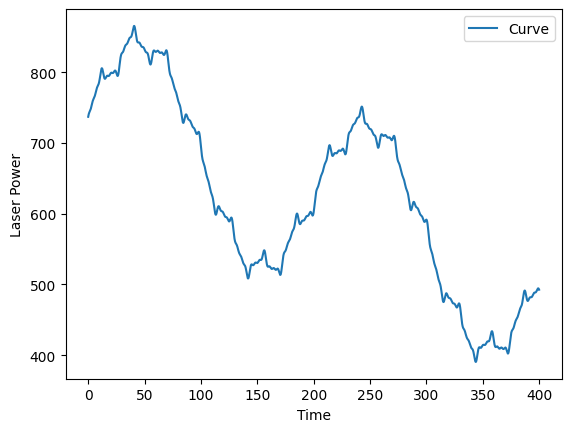

In [2]:
# Importing necessary modules
import numpy as np
import matplotlib.pyplot as plt
# Variables to control frequency and total time
TOTAL_TIME = 400  # in seconds
Time_Step = 0.002  # default frequency


def fourier_series(x, params, rescale_mag=600, rescale_amplitude=50):
    """
    Computes the nth partial sum of the Fourier series with the specified frequency, amplitude, and phase.
    Also includes trend and seasonality.
    """

    # Utility function to normalize a set of values to the range [-1, 1]
    def normalize(x):
        return 2 * (x - np.min(x)) / (np.max(x) - np.min(x)) - 1

    # Utility function to rescale a value from [0, 1] to [min_value, max_value]
    def rescale(x, min_value, max_value):
        return x * (max_value - min_value) + min_value

    # Normalizing the x values to the range [-1, 1]
    x = normalize(x)

    # Extract and scale the parameters for the Fourier series
    n, freq, amplitude, phase, trend, seasonality, = params
    n = int(rescale(n, 0, 10))
    freq = rescale(freq, 0, 10)
    amplitude = rescale(amplitude, 0, 10)
    phase = rescale(phase, 0, 10000)
    trend = rescale(trend, -500, 500)
    seasonality = rescale(seasonality, 0, 200)

    # Compute the Fourier series using the scaled parameters
    sum = np.zeros_like(x)
    for i in range(1, n + 1, 2):
        term = (1 / i) * np.sin(2 * np.pi * freq * i * x + phase)
        sum += term

    y = amplitude * (2 / np.pi) * sum

    # Check if the computed Fourier series is a zero vector. If yes, return a vector of constant values
    if np.sum(y) == 0:
        return np.zeros_like(x) + 600
    else:
        # Scale the computed Fourier series to the range [0, 1]
        y = (y - np.min(y)) / (np.max(y) - np.min(y))
        y = (y * rescale_amplitude) + rescale_mag

    # Add a linear trend to the computed Fourier series
    y += trend * x

    # Add a seasonal pattern to the computed Fourier series
    y += seasonality * np.sin(2 * np.pi * x)

    return y

# Generate x values between 0 and 1000 in 1000 evenly spaced steps
x = np.linspace(0, TOTAL_TIME, int(TOTAL_TIME / 0.002))

# Generate random parameters for the Fourier series
params = np.random.rand(6)

# Compute the Fourier series for the generated x values and random parameters
y = fourier_series(x, params)

# Plot the computed Fourier series
plt.plot(x, y, label=f'Curve')
plt.xlabel("Time")
plt.ylabel("Laser Power")
plt.legend()
plt.show()

# Generate a CSV string of the computed Fourier series and the corresponding x values
output_string = "laser_power,time_elapsed\n"
for i in range(len(x)):
    output_string += f"{y[i]:.15f},{x[i]:.3f}\n"  # Changed the format for x[i] to 3 decimal places

# Save the generated CSV string to a file
with open("/home/vnk3019/ded_dt_thermomechanical_solver/examples/data/laser_inputs/thin_wall/LP.csv", "w") as f:
    f.write(output_string)

## Class of generating laser power 

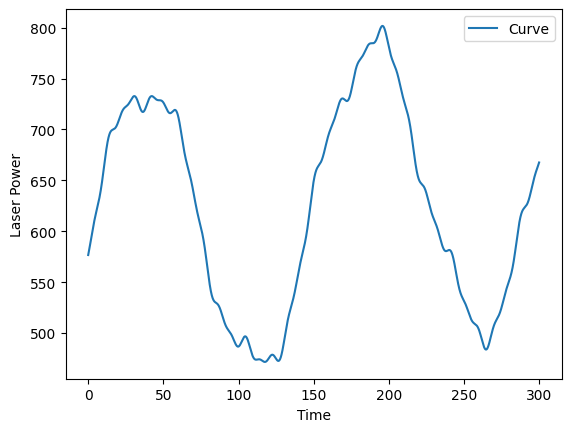

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

class FourierSeriesGenerator:

    def __init__(self, total_time=400, time_step=0.002):
        self.default_total_time = total_time
        self.default_time_step = time_step

    @staticmethod
    def _normalize(x):
        return 2 * (x - np.min(x)) / (np.max(x) - np.min(x)) - 1

    @staticmethod
    def _rescale(x, min_value, max_value):
        return x * (max_value - min_value) + min_value

    def fourier_series(self, x, params, rescale_mag=600, rescale_amplitude=50):
        x = self._normalize(x)

        n, freq, amplitude, phase, trend, seasonality, = params
        n = int(self._rescale(n, 0, 10))
        freq = self._rescale(freq, 0, 10)
        amplitude = self._rescale(amplitude, 0, 10)
        phase = self._rescale(phase, 0, 10000)
        trend = self._rescale(trend, -500, 500)
        seasonality = self._rescale(seasonality, 0, 200)

        sum = np.zeros_like(x)
        for i in range(1, n + 1, 2):
            term = (1 / i) * np.sin(2 * np.pi * freq * i * x + phase)
            sum += term

        y = amplitude * (2 / np.pi) * sum
        if np.sum(y) == 0:
            return np.zeros_like(x) + 600
        else:
            y = (y - np.min(y)) / (np.max(y) - np.min(y))
            y = (y * rescale_amplitude) + rescale_mag

        y += trend * x
        y += seasonality * np.sin(2 * np.pi * x)
        return y

    def plot_and_save(self, params, base_path, iteration, total_time=None, time_step=None):
        if total_time is None:
            total_time = self.default_total_time
        if time_step is None:
            time_step = self.default_time_step

        folder_name = f"Iteration_{iteration}"
        save_directory = os.path.join(base_path, folder_name)
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)  # Create directory if it doesn't exist

        x = np.linspace(0, total_time, int(total_time / time_step))
        y = self.fourier_series(x, params)

        plt.plot(x, y, label=f'Curve')
        plt.xlabel("Time")
        plt.ylabel("Laser Power")
        plt.legend()
        image_path = os.path.join(save_directory, "plot.png")
        plt.savefig(image_path)
        plt.show()

        output_string = "laser_power,time_elapsed\n"
        for i in range(len(x)):
            output_string += f"{y[i]:.15f},{x[i]:.2f}\n"
        csv_path = os.path.join(save_directory, "data.csv")
        with open(csv_path, "w") as f:
            f.write(output_string)

# Example usage:
generator = FourierSeriesGenerator()
params = np.random.rand(6)
base_path = "/home/vnk3019/ded_dt_thermomechanical_solver/examples/data/laser_inputs/thin_wall"
iteration_number = 2
generator.plot_and_save(params, base_path, iteration_number, total_time=300, time_step=0.02)


## Inverse Fourier

In [11]:
import pandas as pd
df = pd.read_excel("/home/vnk3019/ded_dt_thermomechanical_solver/laser_power_data.xlsx")

In [49]:
df["NLP_40"]
last_element = df["NLP_40"].iloc[-1]
print(last_element)
num_rows = len(df)
print(num_rows)
df

221.3147238441714
14252


,NLP_40,NLP_41,NLP_42,NLP_43,NLP_44,NLP_45,NLP_46,NLP_47,NLP_48,NLP_49,...,NLP_66,NLP_67,NLP_68,NLP_69,NLP_70,NLP_71,NLP_72,NLP_73,NLP_74,NLP_75
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,220.728290,167.977663,242.368830,230.234362,240.886751,185.125818,184.513099,275.153225,246.425114,155.349305,...,230.352555,232.472651,220.365257,227.661635,190.560527,199.833645,232.938574,213.184892,248.890935,218.492025
2,220.745465,168.180033,242.447622,230.353234,241.026704,185.509980,184.623857,275.416915,246.557702,155.594555,...,230.396375,232.563982,220.416689,227.770793,190.670711,199.880134,233.080166,213.151755,249.364597,218.510910
3,220.764398,168.414755,242.541018,230.517267,241.192463,185.972276,184.751815,275.745666,246.815352,155.904072,...,230.447799,232.680792,220.476873,227.927316,190.862263,199.932664,233.239027,213.160670,250.050111,218.530564
4,220.783170,168.660104,242.642394,230.719508,241.369204,186.475265,184.886415,276.118055,247.199443,156.259309,...,230.502125,232.816692,220.540351,228.127711,191.147880,199.986100,233.400091,213.240229,250.923453,218.548851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14247,221.314817,167.895906,240.763392,232.040287,240.127764,160.537583,185.146201,276.361040,251.202072,154.596974,...,231.650645,235.813765,220.492796,227.876692,183.276251,203.237958,238.971496,205.775109,257.314329,208.107136
14248,221.314770,167.899174,240.767867,232.062763,240.124490,160.593146,185.148416,276.371897,251.271507,154.604187,...,231.650647,235.817312,220.491778,227.873576,183.288338,203.237777,238.970709,205.796192,257.428922,208.106932
14249,221.314743,167.901947,240.771692,232.080974,240.122927,160.633039,185.149806,276.378296,251.325651,154.611269,...,231.650775,235.820833,220.491211,227.872774,183.306489,203.237665,238.970133,205.818753,257.501548,208.106812
14250,221.314729,167.903716,240.774166,232.092565,240.122132,160.655997,185.150304,276.379810,251.359340,154.615171,...,231.650897,235.823102,220.490931,227.871664,183.318594,203.237601,238.969647,205.833424,257.532889,208.106752


In [50]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

class FourierSeriesGeneratorInverse(FourierSeriesGenerator):

    def fourier_series(self, x, params, rescale_amplitude=50, mean_value=None):
        x = self._normalize(x)

        n, freq, amplitude, phase, trend, seasonality, = params
        n = int(self._rescale(n, 0, 10))
        freq = self._rescale(freq, 0, 10)
        amplitude = self._rescale(amplitude, 0, 10)
        phase = self._rescale(phase, 0, 10000)
        trend = self._rescale(trend, -500, 500)
        seasonality = self._rescale(seasonality, 0, 200)

        sum = np.zeros_like(x)
        for i in range(1, n + 1, 2):
            term = (1 / i) * np.sin(2 * np.pi * freq * i * x + phase)
            sum += term

        y = amplitude * (2 / np.pi) * sum
        if np.sum(y) == 0:
            return np.zeros_like(x) + mean_value  # defaulting to mean_value
        else:
            y = (y - np.min(y)) / (np.max(y) - np.min(y))
            y = (y * rescale_amplitude) + mean_value

        y += trend * x
        y += seasonality * np.sin(2 * np.pi * x)
        return y

    def objective_function(self, params, x, target_output):
        y = self.fourier_series(x, params, mean_value=np.mean(target_output))
        return y - target_output

    def find_parameters(self, x, target_output, initial_guess):
        # Set the bounds for each of the parameters
        lower_bounds = [0, 0, 0, 0, -1, 0]
        upper_bounds = [10, 10, 10, 10000, 1, 200]
        
        result = least_squares(self.objective_function, initial_guess, args=(x, target_output), bounds=(lower_bounds, upper_bounds))
        return result.x

params_dict = {}

columns_to_optimize = ["NLP_40", "NLP_41", "NLP_42", "NLP_43", "NLP_44", "NLP_45", 
                       "NLP_46", "NLP_47", "NLP_48", "NLP_49", "NLP_50", "NLP_51", 
                       "NLP_52", "NLP_53", "NLP_54", "NLP_55", "NLP_56", "NLP_57", 
                       "NLP_58", "NLP_59", "NLP_60", "NLP_61", "NLP_62", "NLP_63", 
                       "NLP_64", "NLP_65", "NLP_66", "NLP_67", "NLP_68", "NLP_69", 
                       "NLP_70", "NLP_71", "NLP_72", "NLP_73", "NLP_74", "NLP_75"]

for col in columns_to_optimize:
    print(f"Optimizing for {col}")
    
    last_element = df[col].iloc[-1]
    num_rows = len(df)
    x = np.linspace(0, int(last_element), num_rows)
    given_laser_power = df[col]
    
    # Adjust initial guess to be within bounds
    initial_guess = [5, 1, 0.5, 0, 0, 0]
    
    # Find the parameters
    optimized_params = generator.find_parameters(x, given_laser_power, initial_guess)
    
    # Store the optimized parameters
    params_dict[col] = optimized_params
    print(f"Optimized parameters for {col}: {optimized_params}")

# Convert the parameters dictionary to a DataFrame and save it as an Excel file
params_df = pd.DataFrame.from_dict(params_dict, orient='index', columns=['n', 'freq', 'amplitude', 'phase', 'trend', 'seasonality'])
params_df.to_excel("optimized_params.xlsx")


Optimizing for NLP_40
Optimized parameters for NLP_40: [5.00000000e+00 9.96864946e-01 3.97671723e+00 1.57878121e-04
 4.99239013e-01 8.69946792e-10]
Optimizing for NLP_41
Optimized parameters for NLP_41: [5.00000000e+00 9.94178414e-01 3.59726646e+00 1.48533741e-04
 4.98927830e-01 6.19220174e-04]
Optimizing for NLP_42
Optimized parameters for NLP_42: [5.00000000e+00 9.97275796e-01 3.73026010e+00 1.58241450e-04
 5.00045807e-01 1.56991791e-25]
Optimizing for NLP_43
Optimized parameters for NLP_43: [5.00000000e+00 9.98035841e-01 6.26337560e+00 1.59717262e-04
 4.99445252e-01 3.31339961e-18]
Optimizing for NLP_44
Optimized parameters for NLP_44: [5.00000000e+00 9.97351466e-01 6.28426057e+00 1.60099401e-04
 4.99873083e-01 7.35362302e-04]
Optimizing for NLP_45
Optimized parameters for NLP_45: [5.00000000e+00 1.01000574e+00 3.74868491e+00 1.57075053e-04
 4.99065051e-01 2.56413940e-03]
Optimizing for NLP_46
Optimized parameters for NLP_46: [5.00000000e+00 1.00050582e+00 6.01694891e+00 1.53240726e

## Data and Laser Power Location

In [2]:
input_data_dir = "/home/vnk3019/ded_dt_thermomechanical_solver/examples/data"
sim_dir_name = "thin_wall"
laser_file = "/home/vnk3019/ded_dt_thermomechanical_solver/examples/data/laser_inputs/thin_wall/LP_2"

## Initiate the FEAModel

In [3]:
sim_itr = rs.FeaModel(
                    input_data_dir= input_data_dir,
                    geom_dir=sim_dir_name,
                    laserpowerfile=laser_file, ## Laser input is given here
                    VtkOutputStep = 1.,
                    ZarrOutputStep = 0.02,
                    outputVtkFiles=True,
                    verbose=True)

Time of reading input files: 1.3773400783538818
Time of calculating critical timestep: 0.8901991844177246
Time of reading and interpolating toolpath: 0.03641104698181152
Number of nodes: 96874
Number of elements: 83270
Number of time-steps: 142500
Time of generating surface: 1.3159127235412598


## Run the Simulation

In [66]:
from gamma_model_simulator import GammaModelSimulator

# Define your parameters
INPUT_DATA_DIR = "/home/vnk3019/ded_dt_thermomechanical_solver/examples/data"
SIM_DIR_NAME = "thin_wall"
LASER_FILE = "/home/vnk3019/ded_dt_thermomechanical_solver/examples/data/laser_inputs/thin_wall/LP"

# Create an instance of the simulator
simulator = GammaModelSimulator(
                    input_data_dir=INPUT_DATA_DIR,
                    sim_dir_name=SIM_DIR_NAME,
                    laser_file=LASER_FILE)

# Set up the simulation
simulator.setup_simulation()

# Run the simulation
simulator.run_simulation()

Time of reading input files: 1.1674394607543945
Time of calculating critical timestep: 0.07886791229248047
Time of reading and interpolating toolpath: 0.03437995910644531
Number of nodes: 96874
Number of elements: 83270
Number of time-steps: 142500
Time of generating surface: 0.4650602340698242
Simulation time:  1.0 s, Percentage done:  0.351%, Elapsed Time: 9.06 s


KeyboardInterrupt: 

## Open the Output File

In [19]:
import zarr
import pandas as pd


# Path to the zarr file
zarr_location = "/home/vnk3019/ded_dt_thermomechanical_solver/examples/data/laser_inputs/thin_wall/LP_2.zarr/ff_dt_temperature"

# Open the zarr file
zarr_array = zarr.open(zarr_location, mode='r')

# Now, you can access the contents of the zarr file through zarr_array like a numpy array.
print(zarr_array.info)

# Convert the zarr array into a pandas DataFrame
df = pd.DataFrame(zarr_array[:])

print(df.head())  # Display the first few rows of the DataFrame


Type               : zarr.core.Array
Data type          : float64
Shape              : (14252, 96874)
Chunk shape        : (1, 96874)
Order              : C
Read-only          : True
Compressor         : None
Store type         : zarr.storage.DirectoryStore
No. bytes          : 11045185984 (10.3G)
No. bytes stored   : 11044411221 (10.3G)
Storage ratio      : 1.0
Chunks initialized : 14251/14252

   0      1      2      3      4      5      6      7      8      9      ...  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1  300.0  300.0  300.0  300.0  300.0  300.0  300.0  300.0  300.0  300.0  ...   
2  300.0  300.0  300.0  300.0  300.0  300.0  300.0  300.0  300.0  300.0  ...   
3  300.0  300.0  300.0  300.0  300.0  300.0  300.0  300.0  300.0  300.0  ...   
4  300.0  300.0  300.0  300.0  300.0  300.0  300.0  300.0  300.0  300.0  ...   

   96864  96865  96866  96867  96868  96869  96870  96871  96872  96873  
0    0.0    0.0    0.0    0.0    0.0    0.0   

## Code to calculate the heat treatment time

Processing nodes:  46%|████▌     | 44734/96874 [00:16<00:19, 2678.65it/s]

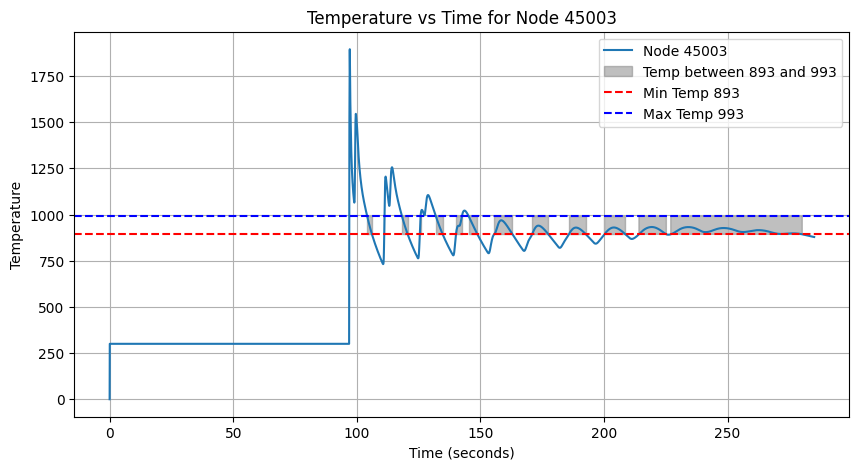

Processing nodes: 100%|██████████| 96874/96874 [00:35<00:00, 2721.67it/s]

The average time taken between temperatures 893-993 for all nodes is: 30.059493775419615 seconds.


In [63]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def calculate_time(df, min_temp, max_temp, selected_nodes, collection_rate=0.02, plot_graph=False):
    total_time_list = []
    
    for column in tqdm(df.columns, desc="Processing nodes"):
        time_axis = np.arange(0, df[column].size * collection_rate, collection_rate)
        
        # Find indices where temperature is within the desired range
        in_range_indices = np.where((df[column] >= min_temp) & (df[column] <= max_temp))[0]
        
        # Check if there are any in-range values
        if len(in_range_indices) == 0:
            total_time_list.append(0)
            continue

        # Calculate time between first and last in-range value for this column
        time_diff = (in_range_indices[-1] - in_range_indices[0]) * collection_rate
        total_time_list.append(time_diff)
        
        # If plotting is enabled and this column is one of the selected nodes, then plot
        if plot_graph and str(column) in selected_nodes:
            plt.figure(figsize=(10,5))
            plt.plot(time_axis, df[column], label=f"Node {column}")
            if len(in_range_indices) > 0:
                plt.fill_between(time_axis, 
                                 min_temp, 
                                 max_temp, 
                                 where=((df[column] >= min_temp) & (df[column] <= max_temp)),
                                 color='gray', alpha=0.5, label=f"Temp between {min_temp} and {max_temp}")
            
            # Adding horizontal lines for min and max temperature
            plt.axhline(min_temp, color='red', linestyle='--', label=f"Min Temp {min_temp}")
            plt.axhline(max_temp, color='blue', linestyle='--', label=f"Max Temp {max_temp}")

            plt.xlabel("Time (seconds)")
            plt.ylabel("Temperature")
            plt.title(f"Temperature vs Time for Node {column}")
            plt.legend()
            plt.grid(True)
            plt.show()
        
    return np.mean(total_time_list)

min_temp, max_temp = 893, 993  # Example thresholds
selected_nodes_list = ["45003"]  # As an example
avg_time = calculate_time(df, min_temp, max_temp, selected_nodes_list, plot_graph=True)
print(f"The average time taken between temperatures {min_temp}-{max_temp} for all nodes is: {avg_time} seconds.")


## Creating the Objective Function

Time of reading input files: 1.5523247718811035
Time of calculating critical timestep: 0.07913565635681152
Time of reading and interpolating toolpath: 0.036163330078125
Number of nodes: 96874
Number of elements: 83270
Number of time-steps: 142500
Time of generating surface: 0.46532511711120605
Simulation time:  1.0 s, Percentage done:  0.351%, Elapsed Time: 9.04 s
Simulation time:  2.0 s, Percentage done:  0.702%, Elapsed Time: 18.2 s
Simulation time:  3.0 s, Percentage done:  1.05%, Elapsed Time: 27.3 s
Simulation time:  4.0 s, Percentage done:  1.4%, Elapsed Time: 36.6 s
Simulation time:  5.0 s, Percentage done:  1.75%, Elapsed Time: 45.9 s
Simulation time:  6.0 s, Percentage done:  2.11%, Elapsed Time: 55.3 s
Simulation time:  7.0 s, Percentage done:  2.46%, Elapsed Time: 64.8 s
Simulation time:  8.0 s, Percentage done:  2.81%, Elapsed Time: 74.3 s
Simulation time:  9.0 s, Percentage done:  3.16%, Elapsed Time: 83.9 s
Simulation time:  1e+01 s, Percentage done:  3.51%, Elapsed Time:

/home/vnk3019/ded_dt_thermomechanical_solver/src/gamma/interface.py:120: UserWarning: Warning! Time steps of LP input are not well aligned with simulation steps
  warnings.warn("Warning! Time steps of LP input are not well aligned with simulation steps")


Simulation time:  1e+02 s, Percentage done:  35.4%, Elapsed Time: 1.18e+03 s
Simulation time:  1e+02 s, Percentage done:  35.8%, Elapsed Time: 1.19e+03 s
Simulation time:  1e+02 s, Percentage done:  36.1%, Elapsed Time: 1.21e+03 s
Simulation time:  1e+02 s, Percentage done:  36.5%, Elapsed Time: 1.22e+03 s
Simulation time:  1e+02 s, Percentage done:  36.8%, Elapsed Time: 1.24e+03 s
Simulation time:  1.1e+02 s, Percentage done:  37.2%, Elapsed Time: 1.25e+03 s
Simulation time:  1.1e+02 s, Percentage done:  37.5%, Elapsed Time: 1.27e+03 s
Simulation time:  1.1e+02 s, Percentage done:  37.9%, Elapsed Time: 1.28e+03 s
Simulation time:  1.1e+02 s, Percentage done:  38.2%, Elapsed Time: 1.3e+03 s
Simulation time:  1.1e+02 s, Percentage done:  38.6%, Elapsed Time: 1.31e+03 s
Simulation time:  1.1e+02 s, Percentage done:  38.9%, Elapsed Time: 1.32e+03 s
Simulation time:  1.1e+02 s, Percentage done:  39.3%, Elapsed Time: 1.34e+03 s
Simulation time:  1.1e+02 s, Percentage done:  39.6%, Elapsed T

Processing nodes:  46%|████▋     | 44954/96874 [00:17<00:20, 2521.42it/s]

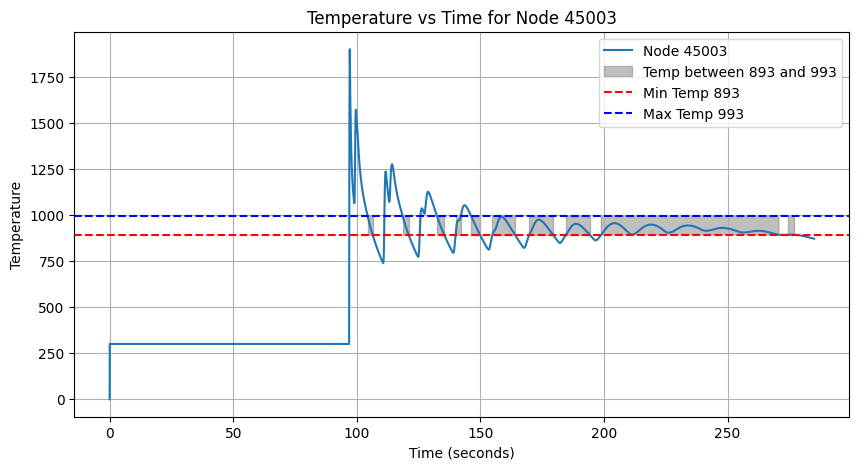

Processing nodes: 100%|██████████| 96874/96874 [00:38<00:00, 2511.21it/s]

The average time taken between temperatures 893-993 for all nodes is: 30.459131449098834 seconds.


In [67]:
from gamma_model_simulator import GammaModelSimulator
import zarr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def run_simulation_and_analyze(INPUT_DATA_DIR, SIM_DIR_NAME, LASER_FILE, ZARR_LOCATION, min_temp, max_temp, selected_nodes_list, collection_rate=0.02, plot_graph=False):

    # Create an instance of the simulator
    simulator = GammaModelSimulator(
                        input_data_dir=INPUT_DATA_DIR,
                        sim_dir_name=SIM_DIR_NAME,
                        laser_file=LASER_FILE)

    # Set up the simulation
    simulator.setup_simulation()

    # Run the simulation
    simulator.run_simulation()

    # Open the zarr file
    zarr_array = zarr.open(ZARR_LOCATION, mode='r')

    # Convert the zarr array into a pandas DataFrame
    df = pd.DataFrame(zarr_array[:])

    return calculate_time(df, min_temp, max_temp, selected_nodes_list, collection_rate, plot_graph)

# Parameters
INPUT_DATA_DIR = "/home/vnk3019/ded_dt_thermomechanical_solver/examples/data"
SIM_DIR_NAME = "thin_wall"
LASER_FILE = "/home/vnk3019/ded_dt_thermomechanical_solver/examples/data/laser_inputs/thin_wall/LP"
ZARR_LOCATION = "/home/vnk3019/ded_dt_thermomechanical_solver/examples/data/laser_inputs/thin_wall/LP.zarr/ff_dt_temperature"
min_temp, max_temp = 893, 993  # Example thresholds
selected_nodes_list = ["45003"]  # As an example

# Call function
avg_time = run_simulation_and_analyze(INPUT_DATA_DIR, SIM_DIR_NAME, LASER_FILE, ZARR_LOCATION, min_temp, max_temp, selected_nodes_list, plot_graph=True)
print(f"The average time taken between temperatures {min_temp}-{max_temp} for all nodes is: {avg_time} seconds.")

## Creating class to get the heat treatment time

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import zarr
import pandas as pd
from tqdm import tqdm
from gamma_model_simulator import GammaModelSimulator

class TemperatureAnalyzer:

    def __init__(self, input_data_dir, sim_dir_name, laser_file):
        self.INPUT_DATA_DIR = input_data_dir
        self.SIM_DIR_NAME = sim_dir_name
        self.LASER_FILE = laser_file

    def calculate_time(self, df, min_temp, max_temp, selected_nodes, collection_rate=0.02, plot_graph=False):  # Notice 'self' added as the first argument
        total_time_list = []
        
        for column in tqdm(df.columns, desc="Processing nodes"):
            time_axis = np.arange(0, df[column].size * collection_rate, collection_rate)
            
            # Find indices where temperature is within the desired range
            in_range_indices = np.where((df[column] >= min_temp) & (df[column] <= max_temp))[0]
            
            # Check if there are any in-range values
            if len(in_range_indices) == 0:
                total_time_list.append(0)
                continue

            # Calculate time between first and last in-range value for this column
            time_diff = (in_range_indices[-1] - in_range_indices[0]) * collection_rate
            total_time_list.append(time_diff)
            
            # If plotting is enabled and this column is one of the selected nodes, then plot
            if plot_graph and str(column) in selected_nodes:
                plt.figure(figsize=(10,5))
                plt.plot(time_axis, df[column], label=f"Node {column}")
                if len(in_range_indices) > 0:
                    plt.fill_between(time_axis, 
                                    min_temp, 
                                    max_temp, 
                                    where=((df[column] >= min_temp) & (df[column] <= max_temp)),
                                    color='gray', alpha=0.5, label=f"Temp between {min_temp} and {max_temp}")
                
                # Adding horizontal lines for min and max temperature
                plt.axhline(min_temp, color='red', linestyle='--', label=f"Min Temp {min_temp}")
                plt.axhline(max_temp, color='blue', linestyle='--', label=f"Max Temp {max_temp}")

                plt.xlabel("Time (seconds)")
                plt.ylabel("Temperature")
                plt.title(f"Temperature vs Time for Node {column}")
                plt.legend()
                plt.grid(True)

                # Save the figure to the same directory as the zarr file, with a specific filename for the node
                figure_path = os.path.join(os.path.dirname(zarr_location), f"Node_{column}_Temperature_vs_Time.png")
                plt.savefig(figure_path)  # Save the figure first
                plt.show()  # Then show the figure
            
        return np.mean(total_time_list)         

    def run_simulation_and_analyze(self, zarr_location, min_temp, max_temp, selected_nodes_list, collection_rate=0.02, plot_graph=False):
        # Create an instance of the simulator
        simulator = GammaModelSimulator(
            input_data_dir=self.INPUT_DATA_DIR,
            sim_dir_name=self.SIM_DIR_NAME,
            laser_file=self.LASER_FILE)

        # Set up the simulation
        simulator.setup_simulation()

        # Run the simulation
        simulator.run_simulation()

        # Open the zarr file
        zarr_array = zarr.open(zarr_location, mode='r')

        # Convert the zarr array into a pandas DataFrame
        df = pd.DataFrame(zarr_array[:])

        return self.calculate_time(df, min_temp, max_temp, selected_nodes_list, collection_rate, plot_graph)



In [ ]:
# Example usage:
analyzer = TemperatureAnalyzer(
    "/home/vnk3019/ded_dt_thermomechanical_solver/examples/data",
    "thin_wall",
    "/home/vnk3019/ded_dt_thermomechanical_solver/examples/data/laser_inputs/thin_wall/LP"
)

ZARR_LOCATION = "/home/vnk3019/ded_dt_thermomechanical_solver/examples/data/laser_inputs/thin_wall/LP.zarr/ff_dt_temperature"
min_temp, max_temp = 893, 993  # Example thresholds
selected_nodes_list = ["45003"]  # As an example

avg_time = analyzer.run_simulation_and_analyze(ZARR_LOCATION, min_temp, max_temp, selected_nodes_list, plot_graph=True)
print(f"The average time taken between temperatures {min_temp}-{max_temp} for all nodes is: {avg_time} seconds.")


In [4]:
import os

# Define the neural network parameters in the following function:
def objective(params, iteration_number, min_temp=893, max_temp=993):
    # Generate and save the Fourier series
    generator = FourierSeriesGenerator()
    base_path = "/home/vnk3019/ded_dt_thermomechanical_solver/examples/data/laser_inputs/thin_wall"
    
    # We use the iteration_number parameter in the plot_and_save method now
    generator.plot_and_save(params, base_path, iteration_number, total_time=30, time_step=0.002)

    # Paths for the simulator
    INPUT_DATA_DIR = "/home/vnk3019/ded_dt_thermomechanical_solver/examples/data"
    SIM_DIR_NAME = "thin_wall"
    
    # Modify LASER_FILE to reflect the correct iteration and CSV filename
    LASER_FILE = os.path.join(base_path, f"Iteration_{iteration_number}", "data")

    # Modify ZARR_LOCATION to reflect the correct iteration
    ZARR_LOCATION = os.path.join(base_path, f"Iteration_{iteration_number}", "data.zarr", "ff_dt_temperature")
    
    min_temp, max_temp = 893, 993  # Example thresholds
    selected_nodes_list = ["45003"]  # As an example

    analyzer = TemperatureAnalyzer(
        INPUT_DATA_DIR,
        SIM_DIR_NAME,
        LASER_FILE
    )

    # Call function
    avg_time = analyzer.run_simulation_and_analyze(ZARR_LOCATION, min_temp, max_temp, selected_nodes_list, plot_graph=True)
    return avg_time  # Now returns a 1D tensor


In [ ]:
import pandas as pd

# Initialize an empty list to store the results
results = []

# Loop for 3 iterations
for iteration in range(1, 4):  # 1 to 3 inclusive
    params = np.random.rand(6)
    avg_time = objective(params, iteration_number=iteration)
    print(f"Iteration {iteration}: Average Time = {avg_time}")

    # Append the current iteration's data to the results list
    results.append({
        'Iteration': iteration,
        'Param1': params[0],
        'Param2': params[1],
        'Param3': params[2],
        'Param4': params[3],
        'Param5': params[4],
        'Param6': params[5],
        'Average_Time': avg_time
    })

# Convert the results list to a DataFrame
df = pd.DataFrame(results)

# Optionally, save the DataFrame to a CSV file
df.to_csv("iterations_results.csv", index=False)

# Print the DataFrame
print(df)


In [24]:
import pandas as pd
import torch

# Load Excel data into a Pandas DataFrame
train_Y = pd.read_excel("avg_heat_treatment_times.xlsx")

# Convert DataFrame to NumPy array and then to PyTorch tensor
train_Y_np = train_Y[["Average Heat Treatment Time"]].values
train_Y_torch = torch.tensor(train_Y_np, dtype=torch.float32)  # Specify dtype if needed

# Now train_X_torch is a PyTorch tensor
train_Y = train_Y_torch

## Bayesian Optimization Loop

In [ ]:
from botorch.fit import fit_gpytorch_model
import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound
from torch.quasirandom import SobolEngine
from tqdm import tqdm  # Import the tqdm module
from botorch.acquisition.objective import ScalarizedPosteriorTransform
import warnings
warnings.filterwarnings("ignore")

# Generate 10 initial random points
# Load Excel data into a Pandas DataFrame
train_X = pd.read_excel("optimized_params.xlsx")

# Convert DataFrame to NumPy array and then to PyTorch tensor
train_X_np = train_X[["n", "freq", "amplitude", "phase", "trend", "seasonality"]].values
train_X_torch = torch.tensor(train_X_np, dtype=torch.float32)  # Specify dtype if needed

# Now train_X_torch is a PyTorch tensor
train_X = train_X_torch

params = train_X[0]

# Assume you have a 2-output model and you want to combine the outputs with equal weight
weights = torch.tensor([0.5])  # Change this to suit your model and task

posterior_transform = ScalarizedPosteriorTransform(weights)

input_size = np.shape(params)[0]

bounds = torch.tensor([[0]*input_size, [1]*input_size], dtype=torch.double)



def initialize_model(bounds):

    # Generate 10 initial random points
    # Load Excel data into a Pandas DataFrame
    train_X = pd.read_excel("optimized_params.xlsx")

    # Convert DataFrame to NumPy array and then to PyTorch tensor
    train_X_np = train_X[["n", "freq", "amplitude", "phase", "trend", "seasonality"]].values
    train_X_torch = torch.tensor(train_X_np, dtype=torch.float32)  # Specify dtype if needed

    # Now train_X_torch is a PyTorch tensor
    train_X = train_X_torch
    # Convert parameters to a suitable format and calculate corresponding Y values


    # Load Excel data into a Pandas DataFrame
    train_Y = pd.read_excel("avg_heat_treatment_times.xlsx")

    # Convert DataFrame to NumPy array and then to PyTorch tensor
    train_Y_np = train_Y[["Average Heat Treatment Time"]].values
    train_Y_torch = torch.tensor(train_Y_np, dtype=torch.float32)  # Specify dtype if needed

    # Now train_X_torch is a PyTorch tensor
    train_Y = train_Y_torch    # Fit a GP model
    gp = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)
    return gp

    
def optimize(bounds, n_steps=100):
    gp = initialize_model(bounds)
    best_value = -float('inf')  # Initialize with negative infinity
    best_params = None

    # Lists to store optimization history
    param_history = []
    value_history = []
    uncertainty_history = []  # Create a list to store the uncertainty at each step

    for i in tqdm(range(n_steps)):
        UCB = UpperConfidenceBound(gp, beta=0.5)
        candidate, _ = optimize_acqf(UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20)
        candidate_numpy = candidate.detach().numpy()
        candidate_numpy = np.array(candidate_numpy.flatten())
        param_dict_from_array = candidate_numpy
        # We use the iteration_number parameter in the plot_and_save method now
        y = generator.plot_and_save(params, base_path, i, total_time=30, time_step=0.002)
        new_Y = objective(param_dict_from_array, iteration = i).unsqueeze(0)

        # Calculate the posterior and its variance
        gp_posterior = gp.posterior(candidate)
        variance = gp_posterior.variance  # This is the uncertainty at the current step
        uncertainty_history.append(variance.item())  # Append the uncertainty to the history list

        if new_Y.item() > best_value:  # Assumes maximization
            best_value = new_Y.item()
            best_params = param_dict_from_array

        param_history.append(param_dict_from_array)
        value_history.append(new_Y.item())

        # Update the GP model with the new data
        gp = SingleTaskGP(
            torch.cat([gp.train_inputs[0], torch.tensor(candidate_numpy).unsqueeze(0)]),
            torch.cat([gp.train_targets.unsqueeze(0).view(-1, 1), new_Y.unsqueeze(0)], dim=0)  # Explicitly specify the dimension for concatenation
        )
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_model(mll)

    return gp, best_params, best_value, param_history, value_history, uncertainty_history

x = np.linspace(0, 100, 1000)
# Run the optimization
optimized_model, best_params, best_value, param_history, value_history, uncertainty_history = optimize(x, bounds)

print(f'Best parameters: {best_params}, Best value: {best_value}')
# Print out the uncertainty history
print('Uncertainty at each step:', uncertainty_history)


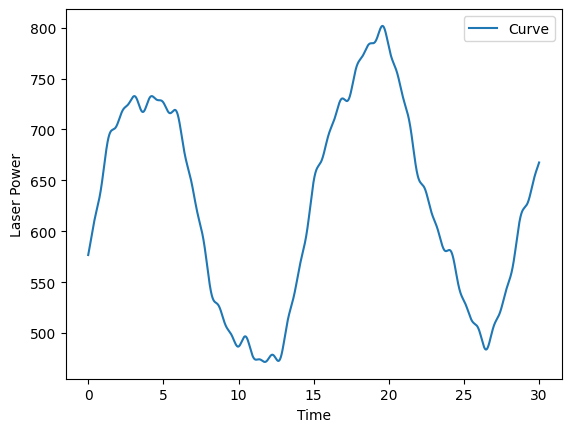

In [7]:
generator = FourierSeriesGenerator()
base_path = "/home/vnk3019/ded_dt_thermomechanical_solver/examples/data/laser_inputs/thin_wall"

# We use the iteration_number parameter in the plot_and_save method now
generator.plot_and_save(params, base_path, iteration_number, total_time=30, time_step=0.002)

  0%|          | 0/5 [00:00<?, ?it/s]

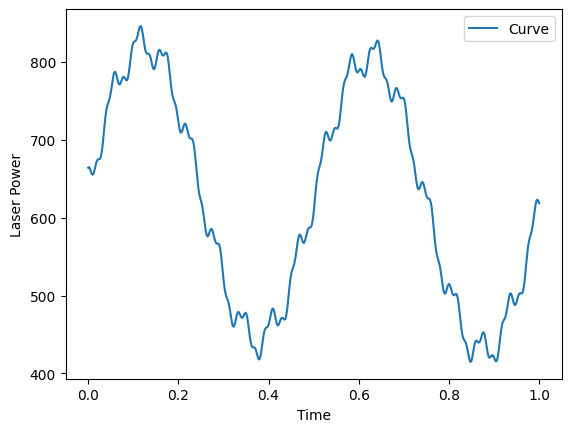

Time of reading input files: 1.152405023574829
Time of calculating critical timestep: 0.07954668998718262
Time of reading and interpolating toolpath: 0.03495383262634277
Number of nodes: 96874
Number of elements: 83270
Number of time-steps: 142500
Time of generating surface: 0.4856138229370117
Simulation time:  1.0 s, Percentage done:  0.351%, Elapsed Time: 9.29 s


 20%|██        | 1/5 [00:29<01:59, 29.96s/it]

tensor([[0.0006]], dtype=torch.float64)
[0.46627662 0.85459304 0.5544952  0.556616   0.48527765 0.92964506]


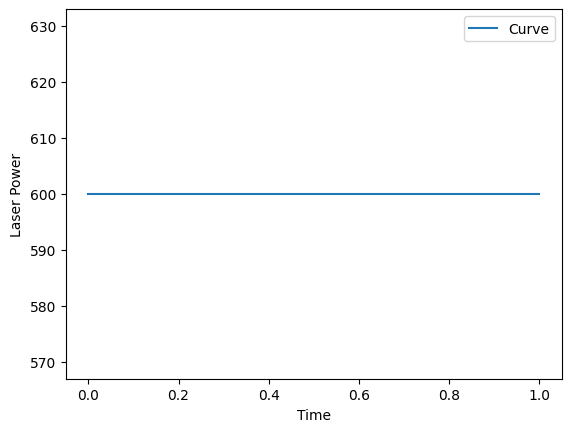

Time of reading input files: 1.1221702098846436
Time of calculating critical timestep: 0.07848143577575684
Time of reading and interpolating toolpath: 0.03400301933288574
Number of nodes: 96874
Number of elements: 83270
Number of time-steps: 142500
Time of generating surface: 0.48352932929992676
Simulation time:  1.0 s, Percentage done:  0.351%, Elapsed Time: 8.98 s


 40%|████      | 2/5 [00:58<01:26, 28.98s/it]

tensor([[0.0005]], dtype=torch.float64)
[1.         0.         0.85323197 0.         1.         0.        ]


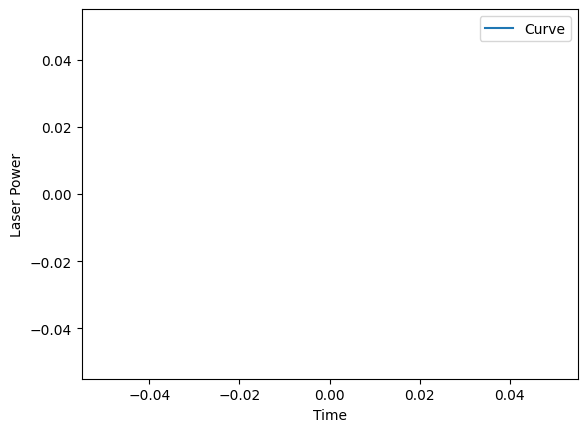

Time of reading input files: 1.5045843124389648
Time of calculating critical timestep: 0.07868194580078125
Time of reading and interpolating toolpath: 0.03462839126586914
Number of nodes: 96874
Number of elements: 83270
Number of time-steps: 142500
Time of generating surface: 0.4686243534088135
Simulation time:  1.0 s, Percentage done:  0.351%, Elapsed Time: 9.24 s


Processing nodes: 100%|██████████| 96874/96874 [00:18<00:00, 5361.51it/s]


tensor([[0.]], dtype=torch.float64)
[1.        0.        0.3900291 1.        0.        0.       ]


 60%|██████    | 3/5 [01:28<00:59, 29.78s/it]

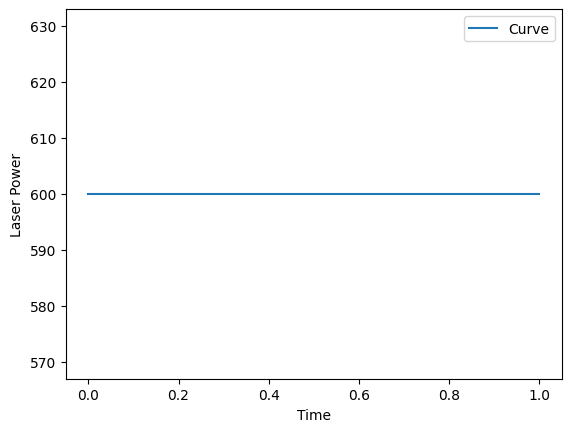

Time of reading input files: 1.1366510391235352
Time of calculating critical timestep: 0.07888650894165039
Time of reading and interpolating toolpath: 0.03582882881164551
Number of nodes: 96874
Number of elements: 83270
Number of time-steps: 142500
Time of generating surface: 0.4941105842590332
Simulation time:  1.0 s, Percentage done:  0.351%, Elapsed Time: 9.22 s


 80%|████████  | 4/5 [01:58<00:29, 29.64s/it]

tensor([[0.0005]], dtype=torch.float64)
[0.         1.         0.75916165 0.         0.         0.        ]


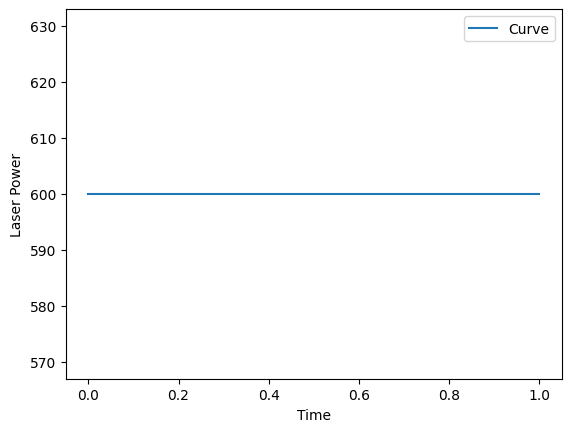

Time of reading input files: 1.5189075469970703
Time of calculating critical timestep: 0.07856345176696777
Time of reading and interpolating toolpath: 0.03384661674499512
Number of nodes: 96874
Number of elements: 83270
Number of time-steps: 142500
Time of generating surface: 0.5005435943603516
Simulation time:  1.0 s, Percentage done:  0.351%, Elapsed Time: 8.98 s


Processing nodes: 100%|██████████| 96874/96874 [00:17<00:00, 5562.06it/s]


tensor([[0.0005]], dtype=torch.float64)
[0. 0. 0. 1. 1. 0.]


100%|██████████| 5/5 [02:27<00:00, 29.56s/it]

Best parameters: [0.46627662 0.85459304 0.5544952  0.556616   0.48527765 0.92964506], Best value: 0.0005677477961062824
Uncertainty at each step: [1.276682734489441, 44.11851119995117, 57.199459075927734, 63.148094177246094, 66.31861114501953]


In [14]:
import os
import numpy as np
import pandas as pd
import zarr
from botorch.fit import fit_gpytorch_model
import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

# Define the neural network parameters in the following function:
def objective(params, iteration_number, min_temp=893, max_temp=993):
    from fourier_generator import FourierSeriesGenerator
    from temperature_analyzer import TemperatureAnalyzer


    # Generate and save the Fourier series
    generator = FourierSeriesGenerator()
    base_path = "/home/vnk3019/ded_dt_thermomechanical_solver/examples/data/laser_inputs/thin_wall"
    generator.plot_and_save(params, base_path, iteration_number, total_time=1, time_step=0.002)

    # Paths for the simulator
    INPUT_DATA_DIR = "/home/vnk3019/ded_dt_thermomechanical_solver/examples/data"
    SIM_DIR_NAME = "thin_wall"

    # Modify LASER_FILE to reflect the correct iteration and CSV filename
    LASER_FILE = os.path.join(base_path, f"Iteration_{iteration_number}", "data")

    # Modify ZARR_LOCATION to reflect the correct iteration
    ZARR_LOCATION = os.path.join(base_path, f"Iteration_{iteration_number}", "data.zarr", "ff_dt_temperature")
    
    selected_nodes_list = ["45003"]  # As an example

    analyzer = TemperatureAnalyzer(
        INPUT_DATA_DIR,
        SIM_DIR_NAME,
        LASER_FILE
    )

    # Call function
    avg_time = analyzer.run_simulation_and_analyze(ZARR_LOCATION, min_temp, max_temp, selected_nodes_list, plot_graph=True)
    return torch.tensor(avg_time)  # Now returns a 1D tensor



# Bayesian Optimization functions
# -----------------------------------------------------------
def initialize_model():
    train_X = pd.read_excel("optimized_params.xlsx")
    train_X_np = train_X[["n", "freq", "amplitude", "phase", "trend", "seasonality"]].values
    train_X_torch = torch.tensor(train_X_np, dtype=torch.float32)
    train_Y = pd.read_excel("avg_heat_treatment_times.xlsx")
    train_Y_np = train_Y[["Average Heat Treatment Time"]].values
    train_Y_torch = torch.tensor(train_Y_np, dtype=torch.float32)
    gp = SingleTaskGP(train_X_torch.float(), train_Y_torch.float())
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)
    return gp

def optimize(bounds, n_steps=5):
    gp = initialize_model()
    best_value = -float('inf')
    best_params = None

    param_history = []
    value_history = []
    uncertainty_history = []

    # Create an empty dataframe with the required columns
    df = pd.DataFrame(columns=['Parameters', 'Objective Value', 'Uncertainty'])

    for i in tqdm(range(n_steps)):
        UCB = UpperConfidenceBound(gp, beta=0.5)
        candidate, _ = optimize_acqf(UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20)
        candidate_numpy = candidate.detach().numpy().flatten()
        new_Y = objective(candidate_numpy, iteration_number=i).unsqueeze(0).unsqueeze(-1)

        variance = gp.posterior(candidate).variance
        uncertainty_history.append(variance.item())

        print(new_Y)
        print(candidate_numpy)

        if new_Y.item() > best_value:
            best_value = new_Y.item()
            best_params = candidate_numpy

        param_history.append(candidate_numpy)
        value_history.append(new_Y.item())

        # Update the Gaussian Process model
        gp = SingleTaskGP(
            torch.cat([gp.train_inputs[0], torch.tensor(candidate_numpy.astype(np.float32)).unsqueeze(0)]),
            torch.cat([gp.train_targets.unsqueeze(-1).float(), new_Y.float()], dim=0)
        )
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_model(mll)

        # Save the current iteration results to the dataframe
        df = df.append({
            'Current Best Parameters': best_params.item(),
            'Current Best Value': best_value.item(), 
            'Parameters': candidate_numpy.tolist(),
            'Objective Value': new_Y.item(),
            'Uncertainty': variance.item()
        }, ignore_index=True)

        # Save the dataframe to an Excel file
        df.to_excel('bayesian_optimization_results.xlsx', index=False)

    return gp, best_params, best_value, param_history, value_history, uncertainty_history
# -----------------------------------------------------------

if __name__ == "__main__":
    input_size = 6  # Assuming 6 parameters
    bounds = torch.tensor([[0]*input_size, [1]*input_size], dtype=torch.float32)
    optimized_model, best_params, best_value, param_history, value_history, uncertainty_history = optimize(bounds)

    print(f'Best parameters: {best_params}, Best value: {best_value}')
    print('Uncertainty at each step:', uncertainty_history)
